# Time Series Prediction


## Introduction

Predicting time series data is useful for a variety of business applications. Companies forecast time series data in order to forecast sales, manage their supply chains, and more.

LSTMs are commonly used for time series prediction because they are able to learn the underlying patterns of time series data. 

In this exercise, we will use an LSTM to forecast the data from a random timeseries by training it on the timeseries.

## Instructions

You can begin forecasting trends with LSTMs with the following steps:

1. Generate your timeseries data in Numpy
2. Load the data into PyTorch
3. Train your model on the data
4. Run the model to predict the next steps in the time series.

## Example Code

<b> Generate X, Y data </b>

In [1]:
# create a sinusoidal dataset
import numpy as np
X = np.arange(100)
Y = np.array([np.sin(x/10) + 0.01*x for x in X])

# create a sinusoidal dataset 6 steps in the future
X_p = np.arange(6, 100+6)
Y_p = np.array([np.sin(x/10) + 0.01*x for x in X_p])

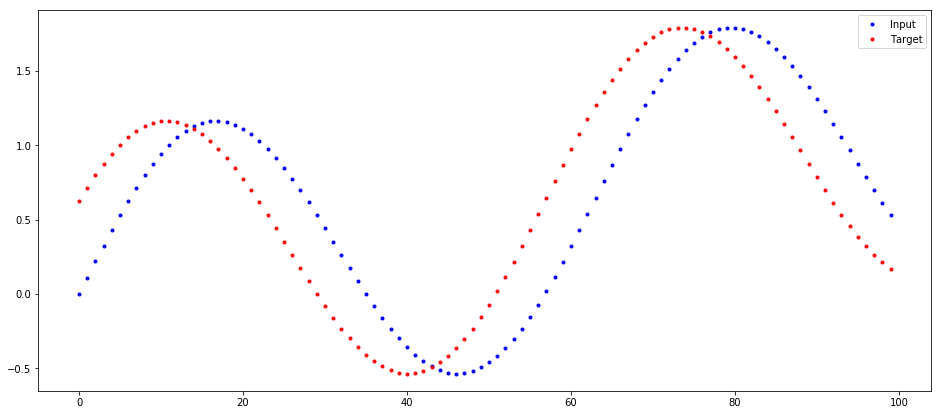

In [2]:
# Visualize graph
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[16, 7])
plt.plot(X, Y, 'b.', label="Input")
plt.plot(X, Y_p, 'r.', label="Target")
plt.legend(loc="best")
plt.show()

<b> Create an LSTM Model </b>

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class LSTM(nn.Module):
    
    def __init__(self, hidden_size, seq_length):
        super(LSTM, self).__init__()
        
        self.seq_length = seq_length
        
        # define 1 LSTM cell which can be used multiple times in the forward method
        self.lstm = nn.LSTMCell(input_size=1, hidden_size=hidden_size)
        
        # to predict a specific value for the next time step, output size of the fc layer should be 1
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, hidden, cell):
        
        # repeat the LSTM cell for times equal to the sequence length
        for i in range(self.seq_length):
            
            # since a LSTMCell only take in one value in the input sequence, each value in x is fed sequentially into each LSTMCell
            # unsqueeze is applied twice to give the input to LSTMCell a shape of (1, 1)
            hidden, cell = self.lstm(x[i].unsqueeze(0).unsqueeze(0), (hidden, cell))
            
            # input's size = (batch size, input size) = (1, 1)
            # hidden's size = (batch size, input size) = (1, 1)
            # cell's size = (batch size, input size) = (1, 1)
            
            output = self.fc(hidden) if i == 0 else torch.cat((output, self.fc(hidden)), dim=0)
        
        return output, hidden, cell

In [5]:
hidden_size = 32
seq_length = 10
pred_steps = 3
i = 0

# test that the dimensions are as expected
test_lstm = LSTM(hidden_size, seq_length)

# generate test data points and convert to Tensors
time_steps = np.arange(i*seq_length, (i+1)*seq_length)
time_steps_pred = np.arange(i*seq_length+pred_steps, (i+1)*seq_length+pred_steps)
data = np.array([np.sin(x/10) + 0.01*x for x in time_steps])
data_pred = np.array([np.sin(x/10) + 0.01*x for x in time_steps_pred])
x_tensor = torch.Tensor(data)
y_tensor = torch.Tensor(data_pred).unsqueeze(1)

print('Input: ', x_tensor)
print('Input size: ', x_tensor.size())
print('Target: ', y_tensor)
print('Target size: ', y_tensor.size())

# initialize cell state and hidden state
init_hidden = torch.zeros(1, hidden_size)
init_cell = torch.zeros(1, hidden_size)

# test lstm sizes
test_out = test_lstm(x_tensor, init_hidden, init_cell)
print('Output: ', test_out[0]) # the forward function returns output, hidden and cell, we only need the output
print('Output size: ', test_out[0].size())

Input:  tensor([ 0.0000,  0.1098,  0.2187,  0.3255,  0.4294,  0.5294,  0.6246,
         0.7142,  0.7974,  0.8733])
Input size:  torch.Size([10])
Target:  tensor([[ 0.3255],
        [ 0.4294],
        [ 0.5294],
        [ 0.6246],
        [ 0.7142],
        [ 0.7974],
        [ 0.8733],
        [ 0.9415],
        [ 1.0012],
        [ 1.0520]])
Target size:  torch.Size([10, 1])
Output:  tensor([[-0.1632],
        [-0.1816],
        [-0.1889],
        [-0.1910],
        [-0.1907],
        [-0.1894],
        [-0.1876],
        [-0.1858],
        [-0.1840],
        [-0.1823]])
Output size:  torch.Size([10, 1])


In [6]:
# train the LSTM
def train(lstm, n_steps, print_every, seq_length, pred_steps, hidden_size):

    # initialize cell state and hidden state
    hidden = torch.zeros(1, hidden_size)
    cell = torch.zeros(1, hidden_size)
    
    for i in range(n_steps):
        
        # define training data and convert to Tensors
        time_steps = np.arange(i*seq_length, (i+1)*seq_length)
        time_steps_pred = np.arange(i*seq_length+pred_steps, (i+1)*seq_length+pred_steps)
        data = np.array([np.sin(x/10) + 0.01*x for x in time_steps])
        data_pred = np.array([np.sin(x/10) + 0.01*x for x in time_steps_pred])
        x_tensor = torch.Tensor(data)
        y_tensor = torch.Tensor(data_pred).unsqueeze(1)
        
        # get output from lstm
        prediction, hidden, cell = lstm(x_tensor, hidden, cell)
        
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden, cell = hidden.data, cell.data        
        
        # calculate loss
        loss = criterion(prediction, y_tensor)
        
        # zero out gradients
        optimizer.zero_grad()
        
        # perform backprop and update weights 
        loss.backward()
        optimizer.step()
        
        # display loss and predictions
        if i % print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps, x_tensor.data.numpy(), 'b.', label="Input") # input
#             plt.plot(time_steps, prediction.data.numpy(), 'r.', label="Prediction") # predictions
            plt.legend(loc="best")
            plt.show()
    
    return lstm

Loss:  0.6004155874252319


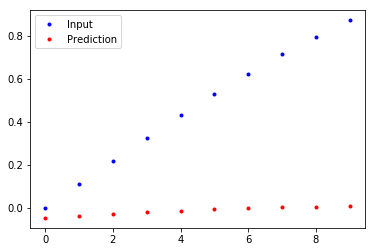

Loss:  18.19597053527832


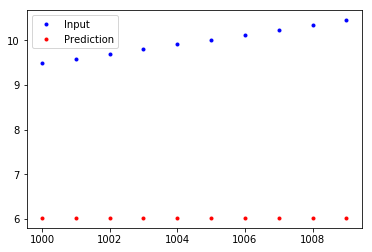

Loss:  64.91828918457031


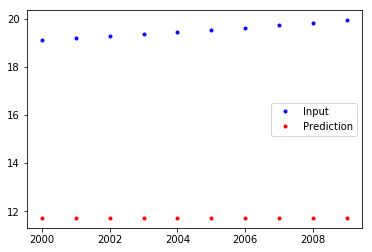

Loss:  147.90103149414062


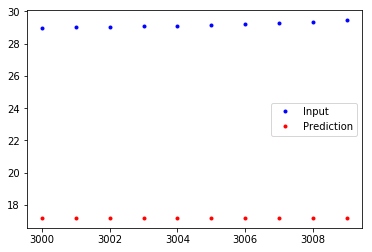

Loss:  272.35772705078125


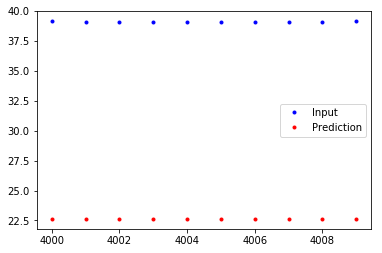

Loss:  447.2931213378906


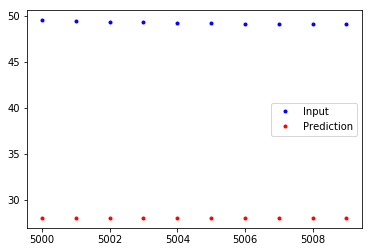

Loss:  680.7894897460938


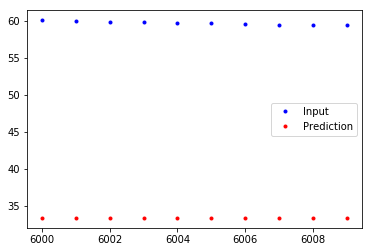

Loss:  976.7501831054688


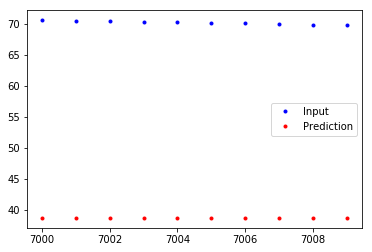

Loss:  1332.7467041015625


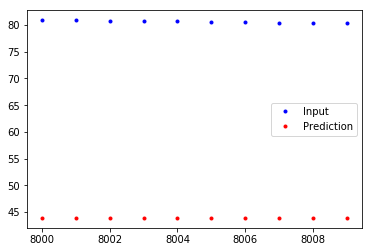

Loss:  1740.1556396484375


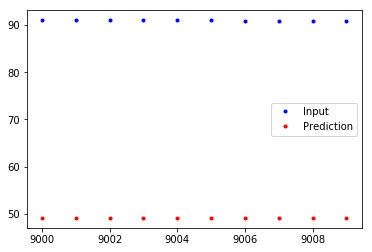

In [7]:
# decide hyperparameters
hidden_size = 32
seq_length = 10
pred_steps = 3

# initiate a LSTM
lstm = LSTM(hidden_size, seq_length)

# define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# train the LSTM and monitor results
n_steps = 1000
print_every = 100

trained_rnn = train(lstm, n_steps, print_every, seq_length, pred_steps, hidden_size)